In [1]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import Token, Contract, Address, BlockNumber

context, model_loader = create_cmf(show=True)

Credmark context created with 
- chain_id=1
- block_number=None (17635708)
- chain_to_provider_url=http://192...8545
- model_loader_path=['/home/yangye/dev/credmark/credmark-models-py/models']
- api_url=https://gateway.credmark.com
- use_local_models=None



In [2]:
from credmark.cmf.model import Model

from credmark.cmf.types import Contract, Token


@Model.describe(
    slug='jit.uniswap-v2-reserve',
    version='1.1',
    input=Contract,
    output=dict)
class UniswapV2Reserve(Model):
    def run(self, input):
        token0_addr = input.functions.token0().call()
        token1_addr = input.functions.token1().call()
        token0 = Token(token0_addr)
        token1 = Token(token1_addr)
        _reserve0, _reserve1, _block_timestamp_last = input.functions.getReserves().call()
        price_token1 = token0.scaled(_reserve0) / token1.scaled(_reserve1)
        return {'price_token1': price_token1,
                'price_token0': 1 / price_token1,
                'reserve0': _reserve0,
                'reserve1': _reserve1}


# We can save this as a file in the models/ directory of credmark-models-py to load it
# Here we directly load it from the definition, with this way, it can only be used in this notebook.
context.add_model(UniswapV2Reserve)

In [3]:
eth_usdc_pool = Contract('0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc')

token0_addr = eth_usdc_pool.functions.token0().call()
token1_addr = eth_usdc_pool.functions.token1().call()

# The addresses of two tokens
print((token0_addr, token1_addr))

# Know what these tokens are actually are
token0 = Token(token0_addr)
token1 = Token(token1_addr)

('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')


In [4]:
# Our ETL process could lag from the current block number, we will fetch events after the last block number from data.
import pandas as pd

with eth_usdc_pool.ledger.events.Sync as q:
    df = q.select(columns=q.columns,
                  where=q.BLOCK_NUMBER.ge(context.block_number-1000),
                  order_by=q.BLOCK_NUMBER.comma_(q.LOG_INDEX)).to_dataframe()


# fetch events directly from node
df_post_events = pd.DataFrame(eth_usdc_pool.fetch_events(
    eth_usdc_pool.events.Sync,
    from_block=(
        (int(df.loc[df.shape[0]-1, 'block_number']) + 1)
        if not df.empty
        else context.block_number-input.block_range),
    to_block=context.block_number))

if not df_post_events.empty:
    df_post_events = (df_post_events
                      .loc[:, ['blockNumber', 'reserve0', 'reserve1']]
                      .rename(columns={'blockNumber': 'block_number'}))

display(df_post_events)

,block_number,reserve0,reserve1
0,17635660,27285107529802,14552491011271803493795
1,17635666,27283127868402,14553550116076209448831
2,17635669,27282847514138,14553700116076209448831
3,17635672,27285409664138,14552337596422126727801
4,17635672,27290365914138,14549702648706612355810
5,17635672,27311612963416,14538417648654013790232
6,17635672,27327012963416,14530249162234484056545
7,17635674,27327227083788,14530135653141652633221
8,17635674,27327130219685,14530187311826927692780
9,17635675,27329112719685,14529136429399775331979


,block_number,reserve0,reserve1
0,17634711,27546571953308,14413204391163287144455
1,17634715,27545294082910,14413875054837142233546
2,17634719,27544213841117,14414442045868485016183
3,17634725,27544713841117,14414181175496310563206
5,17634726,27544733154087,14414172597072621128232
...,...,...,...
210,17635641,27282329954153,14553963012777932859594
211,17635643,27282421529802,14553914307781035096987
212,17635650,27283421529802,14553382473672746651685
213,17635651,27283521529802,14553329292405548623569


,block_number,reserve0,reserve1,price_token1,price_token0
0,17634708,2.754657e+13,14413204391163287144455,1911.203866,0.000523
1,17634709,2.754657e+13,14413204391163287144455,1911.203866,0.000523
2,17634710,2.754657e+13,14413204391163287144455,1911.203866,0.000523
3,17634711,2.754657e+13,14413204391163287144455,1911.203866,0.000523
4,17634712,2.754657e+13,14413204391163287144455,1911.203866,0.000523
...,...,...,...,...,...
1000,17635704,2.732981e+13,14528765134974661110085,1881.083009,0.000532
1001,17635705,2.732981e+13,14528765134974661110085,1881.083009,0.000532
1002,17635706,2.732981e+13,14528765134974661110085,1881.083009,0.000532
1003,17635707,2.733011e+13,14528606132567427238116,1881.124245,0.000532


<Axes: xlabel='block_number'>

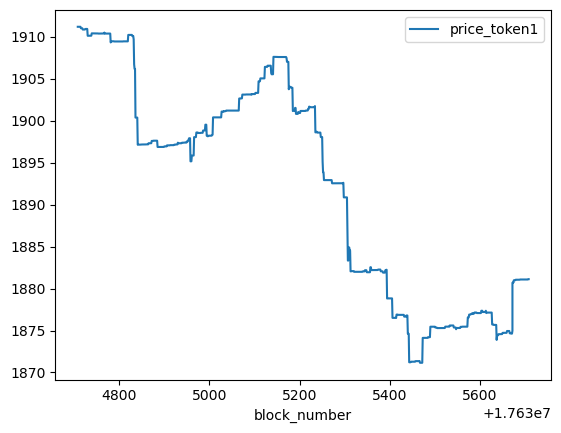

In [5]:
import pandas as pd

df_clean = (df
            .drop_duplicates(subset=['block_number'], keep='last')
            .loc[:, ['block_number', 'evt_reserve0', 'evt_reserve1']]
            .rename(columns={'evt_reserve0': 'reserve0', 'evt_reserve1': 'reserve1'})
            .assign(block_number=lambda x: x.block_number.apply(int),
                    reserve0=lambda x: x.reserve0.apply(int),
                    reserve1=lambda x: x.reserve1.apply(int),))

display(df_clean)

df_clean = pd.concat([df_clean, df_post_events]).reset_index(drop=True)

current_reserve = context.run_model('jit.uniswap-v2-reserve',
                                    {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'})

if df_clean.empty or df_clean.loc[df_clean.shape[0]-1, 'block_number'] != context.block_number:
    df_clean = pd.concat([
        df_clean,
        pd.DataFrame({'block_number': [context.block_number],
                      'reserve0': [current_reserve['reserve0']],
                      'reserve1': [current_reserve['reserve1']]})]).reset_index(drop=True)

df_clean['price_token1'] = token0.scaled(df_clean['reserve0']) / token1.scaled(df_clean['reserve1'])
df_clean['price_token0'] = 1 / df_clean['price_token1']

df_clean = (df_clean
            .merge(pd.DataFrame({'block_number': range(context.block_number-1000, context.block_number+1)}), how='right')
            .sort_values('block_number')
            .fillna(method='ffill')
            .fillna(method='bfill'))

display(df_clean)

df_clean.plot('block_number', 'price_token1')

## 5. Translate above code into a model to return Records for Uniswap V2 pool's price for a block range


In [6]:
# Let's create a model for a range of block numbers
# It support cases when there are > 5000 Sync events in the range, or no event during the

import pandas as pd

from credmark.cmf.model import Model
from credmark.cmf.types import Records
from credmark.dto import DTOField


class ContractWithRange(Contract):
    block_range: int = DTOField(ge=0, description='Block range to query')


@Model.describe(
    slug='jit.uniswap-v2-reserve-range',
    version='1.1',
    input=ContractWithRange,
    output=Records)
class UniswapV2ReserveRange(Model):
    def run(self, input):
        current_reserve = self.context.run_model('jit.uniswap-v2-reserve',
                                                 input)

        token0 = Token(input.functions.token0().call())
        token1 = Token(input.functions.token1().call())

        dfs = []
        with input.ledger.events.Sync as q:
            while True:
                df = q.select(q.columns,
                              where=q.BLOCK_NUMBER.ge(context.block_number-input.block_range),
                              order_by=q.BLOCK_NUMBER.comma_(q.LOG_INDEX)).to_dataframe()

                if not df.empty:
                    dfs.append(df)

                if df.shape[0] < 5000:
                    break

        df_post_events = (pd.DataFrame(input.fetch_events(
            input.events.Sync,
            from_block=(
                (int(df.loc[df.shape[0]-1, 'block_number']) + 1)
                if not df.empty
                else self.context.block_number-input.block_range),
            to_block=self.context.block_number)))

        if not df_post_events.empty:
            df_post_events = (df_post_events
                              .loc[:, ['blockNumber', 'reserve0', 'reserve1']]
                              .rename(columns={'blockNumber': 'block_number'}))

        if len(dfs) == 0:
            df_clean = pd.DataFrame()
        else:
            df_clean = (pd.concat(dfs)
                        .drop_duplicates(subset=['block_number'], keep='last')
                        .loc[:, ['block_number', 'evt_reserve0', 'evt_reserve1']]
                        .rename(columns={'evt_reserve0': 'reserve0', 'evt_reserve1': 'reserve1'})
                        .assign(block_number=lambda x: x.block_number.apply(int),
                                reserve0=lambda x: x.reserve0.apply(int),
                                reserve1=lambda x: x.reserve1.apply(int),))

        df_clean = pd.concat([df_clean, df_post_events]).reset_index(drop=True)

        if df_clean.empty or df_clean.loc[df_clean.shape[0]-1, 'block_number'] != context.block_number:
            df_clean = pd.concat([
                df_clean,
                pd.DataFrame({'block_number': [self.context.block_number],
                              'reserve0': [current_reserve['reserve0']],
                              'reserve1': [current_reserve['reserve1']]})])

        df_clean['price_token1'] = token0.scaled(df_clean['reserve0']) / token1.scaled(df_clean['reserve1'])
        df_clean['price_token0'] = 1 / df_clean['price_token1']

        df_clean = (df_clean
                    .merge(pd.DataFrame({'block_number': range(context.block_number-1000, context.block_number+1)}), how='right')
                    .sort_values('block_number')
                    .fillna(method='ffill')
                    .fillna(method='bfill'))

        return Records.from_dataframe(df_clean)


context.add_model(UniswapV2ReserveRange)

<Axes: xlabel='block_number'>

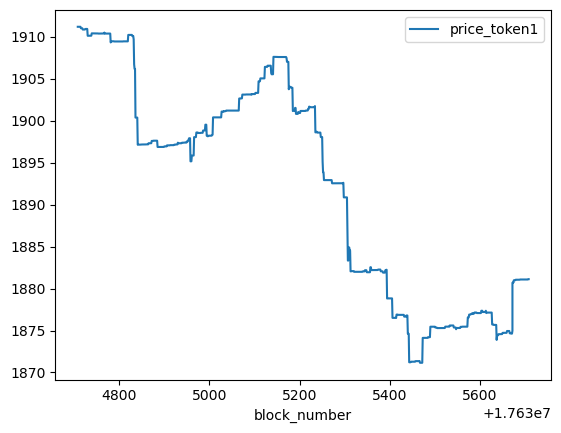

In [7]:
context.reset_cache()
df_range = context.run_model('jit.uniswap-v2-reserve-range',
                             {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc', 'block_range': 1000},
                             return_type=Records).to_dataframe()

df_range.plot('block_number', 'price_token1')